In [1]:
from utils.common_imports import *
from IPython.display import display

# Get a annotation:
all_annotations: list[pl.Annotation] = pl.query(pl.Annotation).all()

In [2]:
def get_roi_slices(ann: pl.Annotation, padding: int = 50) -> tuple[np.ndarray, np.ndarray]:
    """Given a annotation, returns a padded ROI volume and the dimensions of the bounding box of the ROI in the full scan."""
    vol = ann.scan.to_volume(verbose=False)
    roi_scan_bbox = ann.bbox()
    padded_roi_bbox = ann.bbox(pad=padding)
    return vol[padded_roi_bbox], roi_scan_bbox, padded_roi_bbox


def visualise_roi(ann: pl.Annotation, padding: int = 50, n_append: int = 5, show_contours: bool = True) -> None:
    # Annotated slices
    # TODO add all other annotations for the same nodule
    ann_scan_slice_idxs = ann.contour_slice_indices
    ann_scan_slice_start_idx = int(ann_scan_slice_idxs[0])
    ann_scan_slice_end_idx = int(ann_scan_slice_idxs[-1])

    # get the ROI and its bounding box in the scan
    roi, roi_scan_bbox, padded_roi_scan_bbox = get_roi_slices(ann, padding=padding)

    # Subset the scans in the ROI that are annotated
    pad_slice_min = padded_roi_scan_bbox[-1].start
    pad_slice_max = padded_roi_scan_bbox[-1].stop
    lower_bound = ann_scan_slice_start_idx - pad_slice_min
    upper_bound = pad_slice_max - ann_scan_slice_end_idx
    roi_annotated_subset = roi[:, :, lower_bound:-upper_bound + 1]

    assert roi_annotated_subset.shape[-1] == len(ann_scan_slice_idxs), "The number of annotated slices in the ROI does not match the number of annotated slices in the annotation."

    # Append n_append equally spaced slices before and after the annotated slices
    front_append_slice_idxs = np.linspace(start=0, stop=lower_bound, num=n_append, dtype=int)
    back_append_slice_idxs = np.linspace(start=upper_bound, stop=roi.shape[-1] - 1, num=n_append, dtype=int)
    roi_concat = np.concatenate([roi[:,:,front_append_slice_idxs], roi_annotated_subset, roi[:,:,back_append_slice_idxs]], axis=-1)

    # Now display the slices in @roi_concat
    annotated_start_idx = n_append
    annotated_end_idx = n_append + len(ann_scan_slice_idxs)

    n_slices = roi_concat.shape[-1]
    n_cols = 4
    n_rows = (n_slices + n_cols -1) // n_cols

    # for rescaling of the contours to match the crop:
    padded_roi_bbox_x_min = int(padded_roi_scan_bbox[1].start)
    padded_roi_bbox_y_min = int(padded_roi_scan_bbox[0].start)

    malignancy_desc = ["Highly Unlikely",
    "Moderately Unlikely",
    "Indeterminate",
    "Moderately Suspicious",
    "Highly Suspicious"]

    # Plot figure:
    all_contours = ann.contours
    _, axs = plt.subplots(n_rows, n_cols, figsize=(10,6))
    for i in range(n_slices):
        ax = axs[i//n_cols, i%n_cols]
        ax.imshow(roi_concat[:,:,i], cmap='gray')

        if annotated_start_idx <= i < annotated_end_idx and show_contours:
            # if the image is an annotated slice, plot the contours
            ax.set_title(f"Annotated. Malignancy: ({ann.malignancy}) {malignancy_desc[ann.malignancy - 1]}")
            con = all_contours[i - annotated_start_idx]
            ii, jj = con.to_matrix(include_k=False).T
            # Rescale the contours to match the crop:
            jj = jj - padded_roi_bbox_x_min
            ii = ii - padded_roi_bbox_y_min
            ax.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")

        else:
            # ax.set_title(f"Not Annotated")
            ax.axis('off')
            continue
        ax.axis('off')

    plt.suptitle(f"Annotation ID: {ann.id} - scan ID: {ann.scan.id} - padding: {padding}")
    plt.tight_layout()
    plt.show()

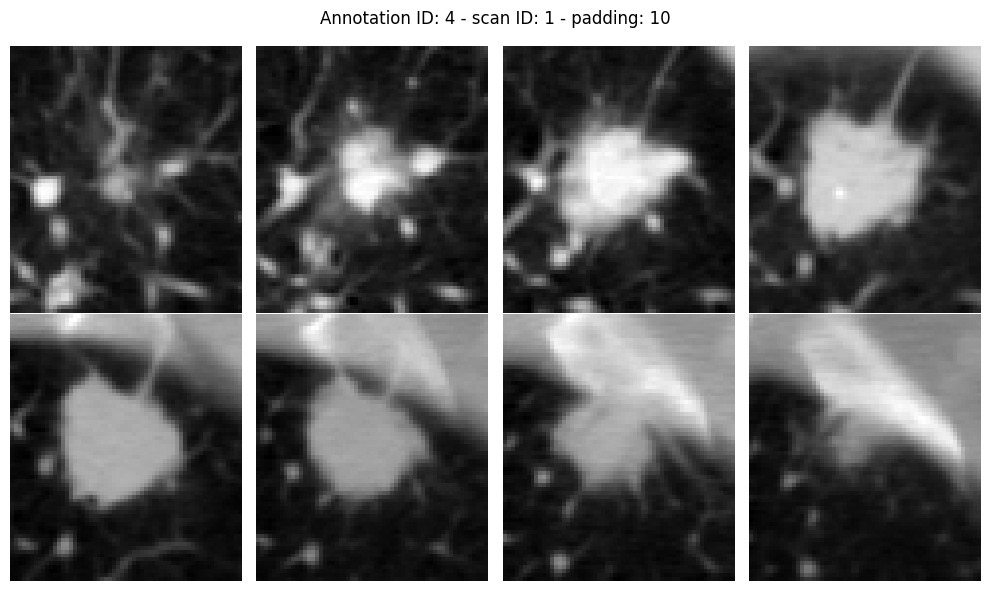

In [3]:
ann = all_annotations[3]
visualise_roi(ann, padding=10, n_append=0, show_contours=False)

Loading dicom files ... This may take a moment.


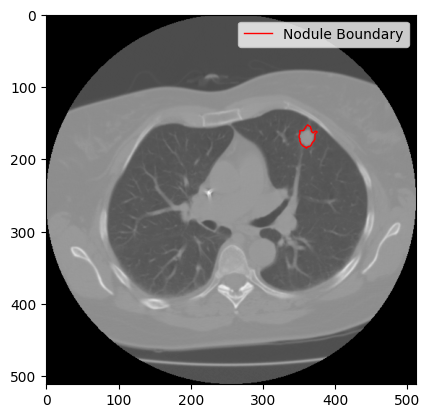

In [4]:
ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()

# Inspecting different nodule bbox sizes 

THIS IS NOW DONE ON THE RESAMPLED CT SCANS!!! (so they have 1mm x 1mm x 1mm voxel size)

In [2]:
import pandas as pd
import ast
import pylidc as pl
import matplotlib.pyplot as plt

nodule_df = pd.read_csv("preprocessing/processed_nodule_df.csv")
image_dims = [20,30,40,50,60,70]

for img_dim in image_dims:
    nodule_df[f"consensus_bbox_{img_dim}"] = nodule_df[
        f"consensus_bbox_{img_dim}"
    ].apply(ast.literal_eval)

print(nodule_df.columns)
nodule_df.head(3)

Index(['nodule_id', 'scan_id', 'nodule_idx', 'scan_slice_thickness',
       'scan_slice_spacing', 'scan_pixel_spacing', 'scan_contrast_used',
       'malignancy_scores', 'subtlety_scores', 'ann_internalStructure_scores',
       'ann_calcification_scores', 'ann_sphericity_scores',
       'ann_margin_scores', 'ann_lobulation_scores', 'ann_spiculation_scores',
       'ann_texture_scores', 'nodule_annotation_ids',
       'nodule_annotation_count', 'ann_mean_diameter', 'ann_mean_volume',
       'consensus_centroid', 'scaling_factors', 'consensus_bbox_10',
       'consensus_bbox_20', 'consensus_bbox_30', 'consensus_bbox_40',
       'consensus_bbox_50', 'consensus_bbox_60', 'consensus_bbox_70',
       'consensus_bbox_80', 'consensus_bbox_90', 'consensus_bbox_100',
       'malignancy_consensus', 'cancer_label', 'subtlety_consensus',
       'internalStructure_consensus', 'calcification_consensus',
       'sphericity_consensus', 'margin_consensus', 'lobulation_consensus',
       'spiculation_con

,nodule_id,scan_id,nodule_idx,scan_slice_thickness,scan_slice_spacing,scan_pixel_spacing,scan_contrast_used,malignancy_scores,subtlety_scores,ann_internalStructure_scores,...,bbox_10_standardised,bbox_20_standardised,bbox_30_standardised,bbox_40_standardised,bbox_50_standardised,bbox_60_standardised,bbox_70_standardised,bbox_80_standardised,bbox_90_standardised,bbox_100_standardised
0,LIDC-IDRI-0001_0,LIDC-IDRI-0001,0,2.50,2.50,0.703125,True,"(5, 5, 5, 4)","(5, 5, 5, 5)","(1, 1, 1, 1)",...,True,True,True,True,True,True,True,True,True,True
1,LIDC-IDRI-0002_0,LIDC-IDRI-0002,0,1.25,1.25,0.681641,False,"(5, 4)","(2, 1)","(1, 1)",...,True,True,True,True,True,True,True,True,True,True
2,LIDC-IDRI-0003_0,LIDC-IDRI-0003,0,2.50,2.50,0.820312,True,"(2,)","(1,)","(1,)",...,True,True,True,True,True,True,True,True,True,True


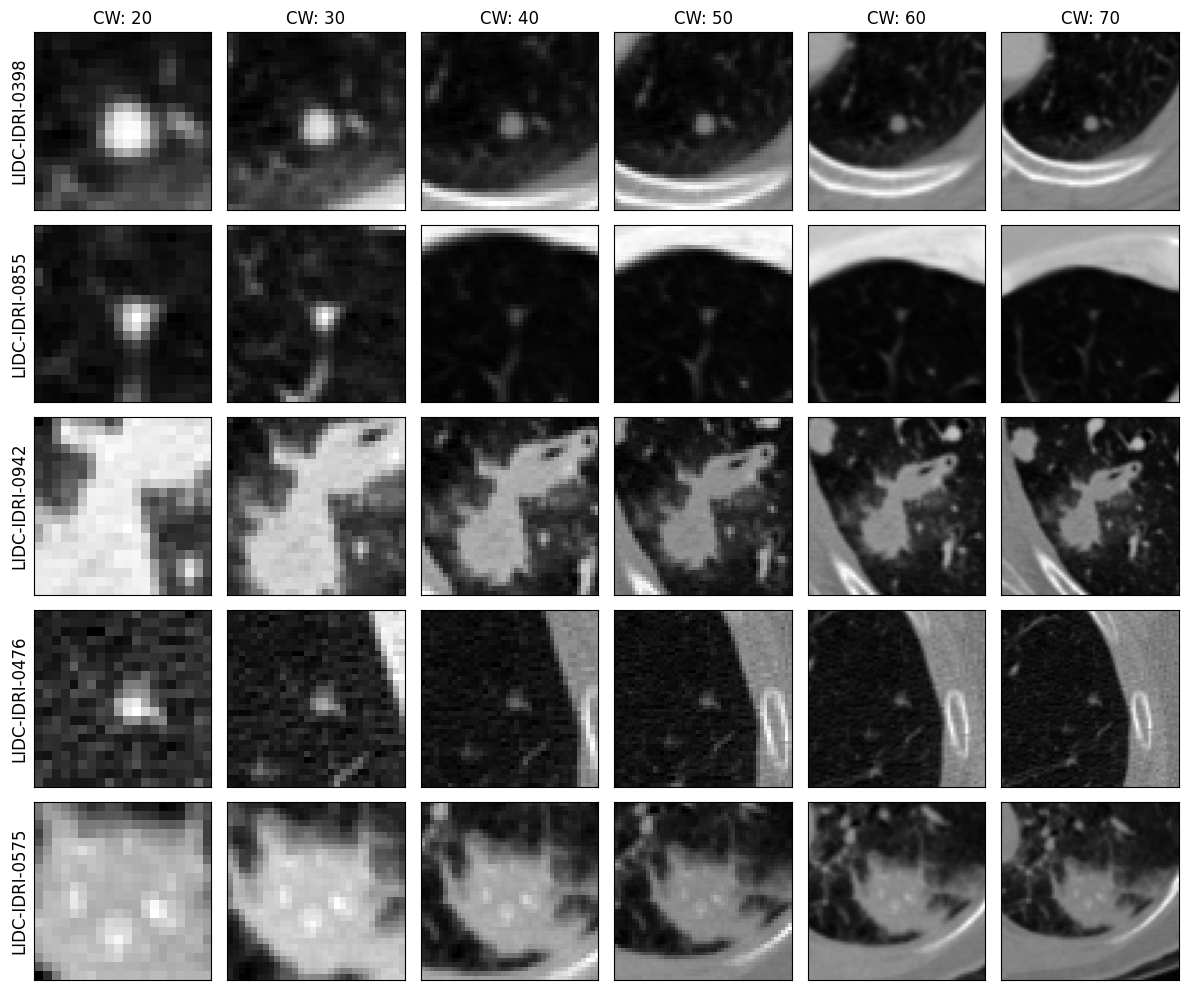

In [3]:
from preprocessing.processing import resample_voxel_size

# PLOT PARAMS
samples = 5
x_size, y_size = 12, 10
# ---

view_nodules = nodule_df.sample(samples)
n_cols = len(image_dims)

fig, ax = plt.subplots(nrows=samples, ncols=n_cols, figsize=(x_size, y_size), layout="tight")

# for each sample...
for i, (_, row) in enumerate(view_nodules.iterrows()):
    nodule_scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == row["scan_id"]).first().to_volume(verbose=False)
    resampled_scan, _ = resample_voxel_size(nodule_scan, row["scan_pixel_spacing"], row["scan_slice_thickness"])
    nodules_consensus_bboxs = [row[f"consensus_bbox_{img_dim}"] for img_dim in image_dims]

    # for each context size...
    for j, (x, y, z) in enumerate(nodules_consensus_bboxs):
        bbox = resampled_scan[x[0] : x[1], y[0] : y[1], z[0] : z[1]]
        middle_slice = bbox.shape[-1] // 2
        ax[i, j].imshow(bbox[:,:, middle_slice], cmap=plt.cm.gray)

        if i == 0:
            ax[i, j].set_title(f"CW: {image_dims[j]}", fontsize=12)
        if j == 0:
            ax[i, j].set_ylabel(f"{row['scan_id']}", fontsize=12)

        # Hide ticks but keep labels:
        ax[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig("report/plots/nodule_examples.png")
plt.show()

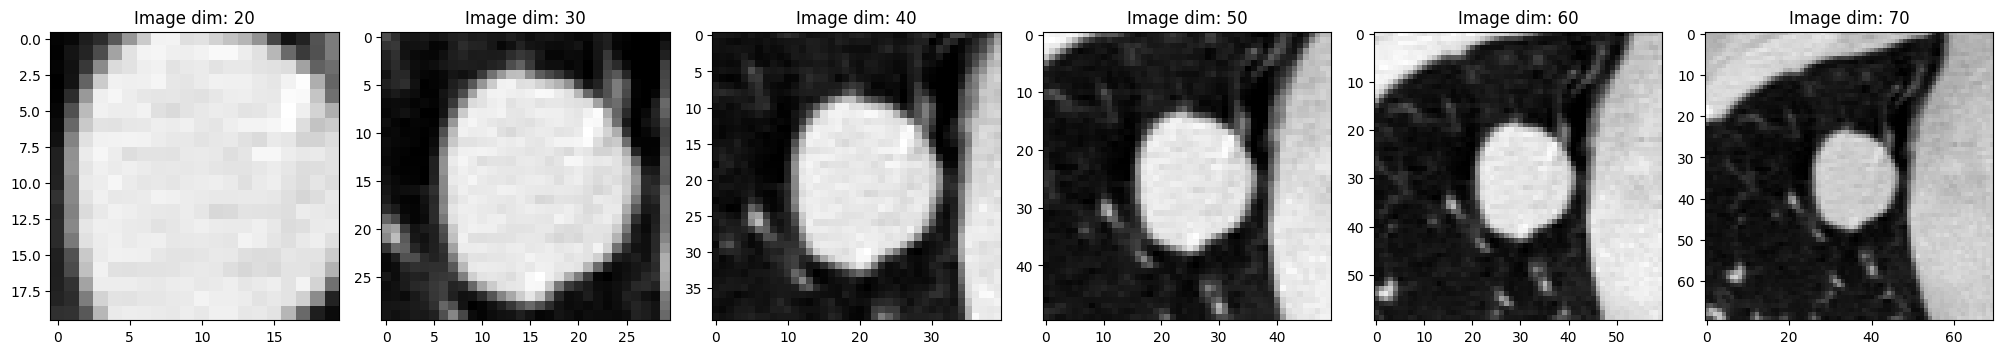

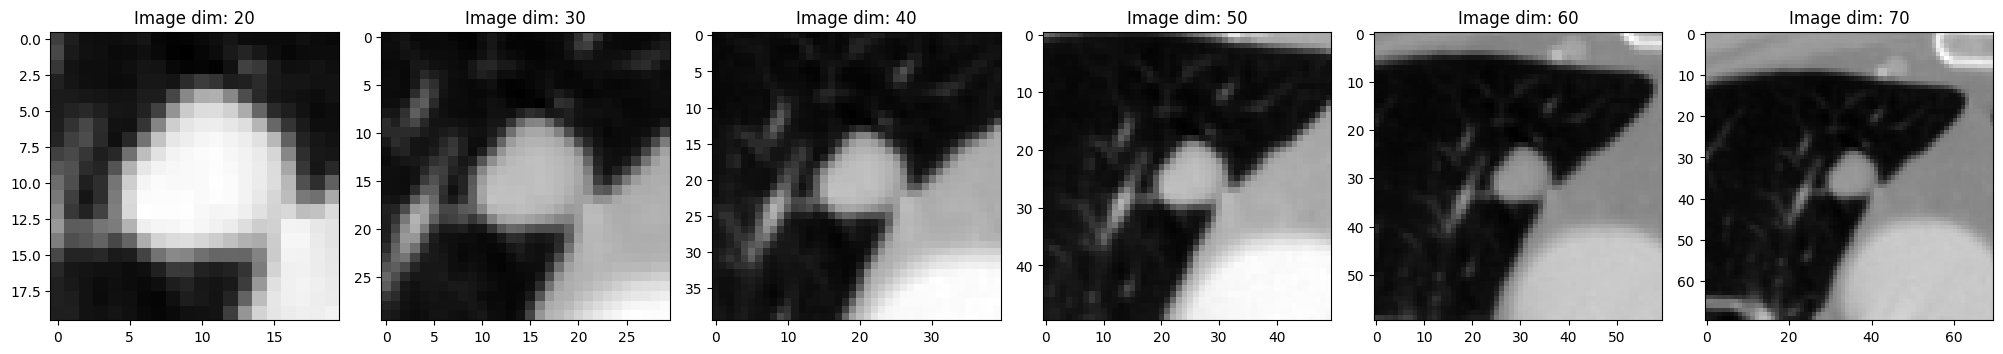

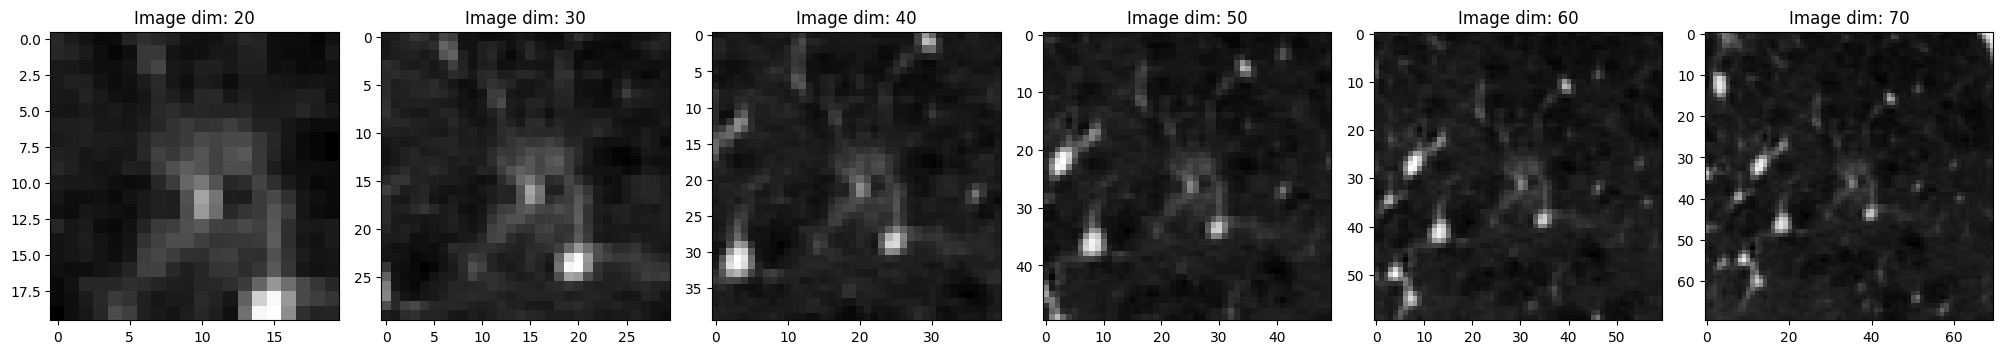

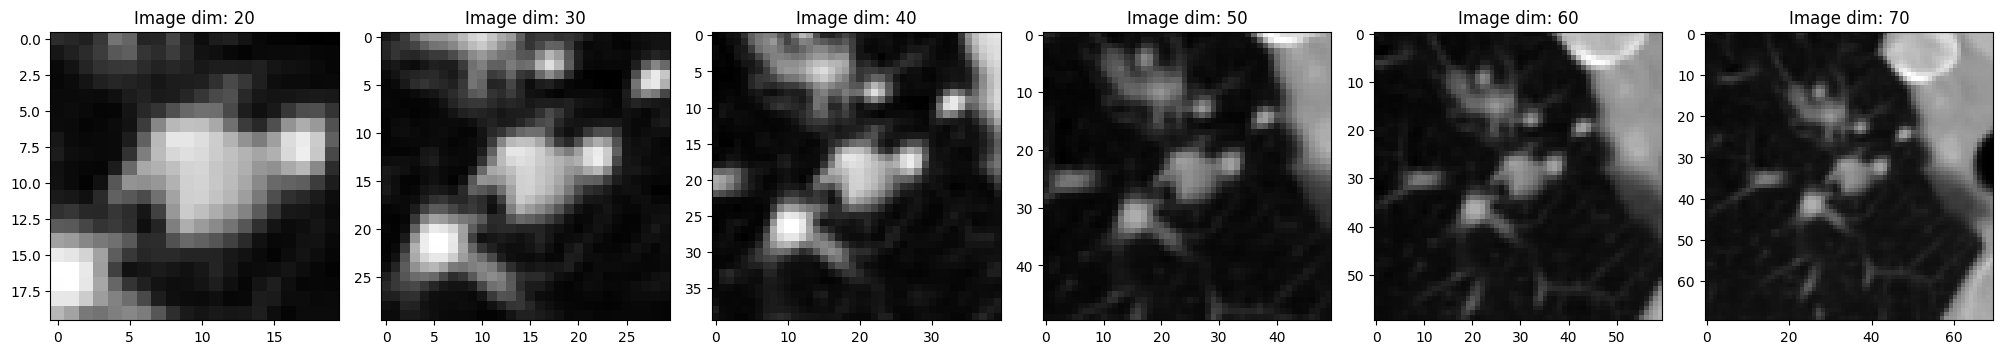

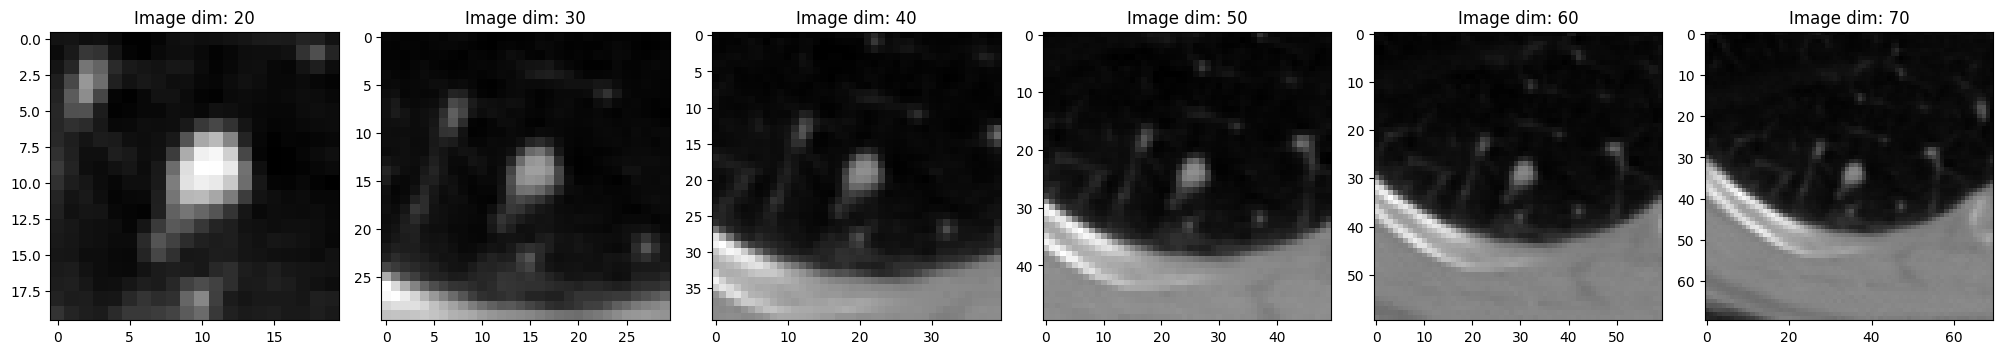

In [7]:
# NOTE: this is not a single plot, but multiple for each nodule
from preprocessing.processing import resample_voxel_size

view_nodules = nodule_df.sample(5)

for i, row in view_nodules.iterrows():
    nodule_scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == row["scan_id"]).first().to_volume(verbose=False)
    resampled_scan, _ = resample_voxel_size(nodule_scan, row["scan_pixel_spacing"], row["scan_slice_thickness"])
    nodules_consensus_bboxs = [row[f"consensus_bbox_{img_dim}"] for img_dim in image_dims]

    fig, ax = plt.subplots(1, len(image_dims), figsize=(20, 10))
    for i, (x_size, y_size, z) in enumerate(nodules_consensus_bboxs):
        bbox = resampled_scan[x_size[0] : x_size[1], y_size[0] : y_size[1], z[0] : z[1]]
        middle_slice = bbox.shape[-1] // 2
        ax[i].imshow(bbox[:,:, middle_slice], cmap=plt.cm.gray)
        ax[i].set_title(f"Image dim: {image_dims[i]}")
    plt.tight_layout()
    plt.show()